In [1]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community.community_louvain as community_louvain
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

In [2]:
# Read datasets/papers.csv into papers
papers = pd.read_csv("papers.csv")

# Print out the first rows of papers
papers.head()

authors = pd.read_csv("authors.csv")
assc = pd.read_csv("paper_authors.csv")


In [3]:
assc.head()

,id,paper_id,author_id
0,1,63,94
1,2,80,124
2,3,80,125
3,4,80,126
4,5,80,127


In [4]:
authors.head()

,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser


In [5]:
df = assc.merge(authors, left_on="author_id", right_on="id")[["paper_id", "name", "author_id"]]
df = df.merge(papers, left_on="paper_id", right_on="id")[["paper_id", "author_id", "name", "year", "title", "abstract", "paper_text"]]

In [6]:
df.head()

,paper_id,author_id,name,year,title,abstract,paper_text
0,63,94,Yaser S. Abu-Mostafa,1987,Connectivity Versus Entropy,Abstract Missing,1\n\nCONNECTIVITY VERSUS ENTROPY\nYaser S. Abu...
1,157,94,Yaser S. Abu-Mostafa,1988,On the K-Winners-Take-All Network,Abstract Missing,634\n\nON THE K-WINNERS-TAKE-ALL NETWORK\nE. M...
2,157,257,E. Majani,1988,On the K-Winners-Take-All Network,Abstract Missing,634\n\nON THE K-WINNERS-TAKE-ALL NETWORK\nE. M...
3,157,258,Ruth Erlanson,1988,On the K-Winners-Take-All Network,Abstract Missing,634\n\nON THE K-WINNERS-TAKE-ALL NETWORK\nE. M...
4,206,94,Yaser S. Abu-Mostafa,1989,A Method for the Associative Storage of Analog...,Abstract Missing,590\n\nAtiya and Abu-Mostafa\n\nA Method for t...


In [7]:
# Initialize graph
G = nx.Graph()

# Transform
# REMARK: The algorithm seems more stable by doing '*=2' than '+=1'
# REMARK: I use 'name' instead of 'author_id' for label purposes.
for p, a in df.groupby('paper_id')['name']: 
    for u, v in itertools.combinations(a, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] *= 2
        else:
            G.add_edge(u, v, weight=1)
G.remove_edges_from(list(nx.selfloop_edges(G)))           
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 22145


In [8]:
# Get best partition
partition = community_louvain.best_partition(G)
print('Modularity: ', community_louvain.modularity(partition, G))

Modularity:  0.37992465498483174


In [9]:
# Keep only communities with a minimum of authors
centers = {}
communities = {}
G_main_com = G.copy()
min_nb = 300
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        # Print community
        print('Community of ', center , '(ID ', com, ') - ', len(list_nodes), ' authors:')
        print(list_nodes, '\n')

Community of  Bernhard Sch?lkopf (ID  2 ) -  650  authors:
['John C. Platt', 'Alan H. Barr', 'Avrim Blum', 'Anya Hurlbert', 'Tomaso Poggio', 'Clay D. Spence', 'John C. Pearson', 'J. J. Gelfand', 'R. M. Peterson', 'W. E. Sullivan', 'Federico Girosi', 'L?on Bottou', 'Ronald Sverdlove', 'Bill Baird', 'Frank Eeckman', 'Bruno Caprile', 'Robert C. Williamson', 'Federico Faggin', 'David Kirk', 'Kurt Fleischer', 'Lloyd Watts', 'Alan Barr', 'Christopher J. C. Burges', 'Janeen Anderson', 'David B. Kirk', 'Harris Drucker', 'Douglas Kerns', 'Uwe Helmke', 'Todd Troyer', 'Leif H. Finkel', 'Paul Sajda', 'Eric Cosatto', 'Vladimir Vapnik', 'K? Sakai', 'Ralph Wolf', 'Joachim M. Buhmann', 'Martin Lades', 'Adam Kowalczyk', 'Herman L. Ferr?', 'Clay Spence', 'Jim Bergen', 'Manfred K. Warmuth', 'Mark Herbster', 'Klaus-Robert M?ller', 'Jacek Szymanski', 'David P. Helmbold', 'Jyrki Kivinen', 'Peter K. Campbell', 'Michael Dale', 'John Shawe-Taylor', 'Jieyu Zhao', 'Timothy P. Allen', 'Lucas C. Parra', 'Andreas Z

In [10]:
print(communities)

{2: 'Bernhard Sch?lkopf', 5: 'Yoshua Bengio', 9: 'Michael I. Jordan', 10: 'Sham M. Kakade', 15: 'Rong Jin', 24: 'Wulfram Gerstner', 39: 'Liam Paninski', 200: 'Eric P. Xing'}


In [11]:
print(df[df["name"] == 'Shuicheng Yan']["name"].count())

11


In [12]:
df.groupby("name")['name'].count().sort_values(ascending=False).to_csv("num_pub_per_authors.csv")
df_author = df.groupby("name")['name'].count().sort_values(ascending=False)

In [13]:
partitions_louvain = []
min_nb = 10
for com in set(partition.values()) :
    temp = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(temp) >= min_nb:
        partitions_louvain.append(temp)

partitions_louvain.sort(key=len, reverse=True)

In [14]:
df_author = df.groupby("name")['name'].count().sort_values(ascending=False)

In [15]:
from numpy import mean, std
x = []
y = []
for i, p in enumerate(partitions_louvain):
    temp = [df_author[name] for name in p]
    avg, sd, mn, mx = mean(temp), std(temp), min(temp), max(temp)
    x.append(len(p))
    y.append(avg)
    if i < 3:
        print(f"Size of {i}-th partition is {len(p)}")
        print(f"mean of {i}-th partition is {avg}")
        print(f"std of {i}-th partition is {sd}")
        print(f"min of {i}-th partition is {mn}")
        print(f"max of {i}-th partition is {mx}")
        print("------------------------------------")

Size of 0-th partition is 1715
mean of 0-th partition is 2.4857142857142858
std of 0-th partition is 3.994340018900359
min of 0-th partition is 1
max of 0-th partition is 60
------------------------------------
Size of 1-th partition is 1155
mean of 1-th partition is 2.4995670995670998
std of 1-th partition is 4.659371209974311
min of 1-th partition is 1
max of 1-th partition is 101
------------------------------------
Size of 2-th partition is 813
mean of 2-th partition is 2.6678966789667897
std of 2-th partition is 3.766939126849374
min of 2-th partition is 1
max of 2-th partition is 35
------------------------------------


In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np
model = LinearRegression()
x = np.array(x)
y = np.array(y)
x = x.reshape(-1,1)
model = model.fit(x,y)


In [17]:
r_sq = model.score(x, y)
r_sq

0.30221313673005556

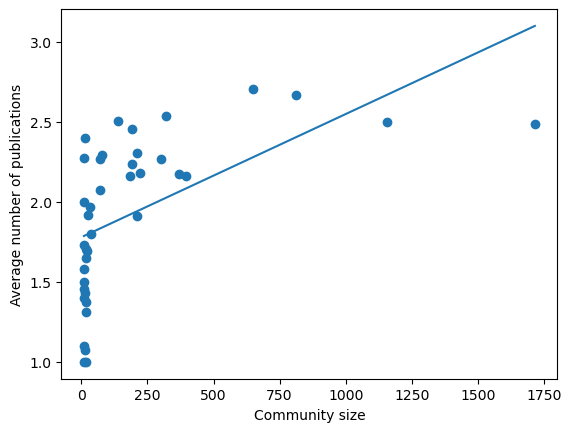

In [18]:
import matplotlib.pyplot as plt

plt.scatter(x,y)
plt.plot(x, model.coef_*x + model.intercept_)
plt.xlabel("Community size")
plt.ylabel("Average number of publications")
plt.show()

In [19]:
import leidenalg as la
import igraph

iG = igraph.Graph.from_networkx(G)

In [20]:
leiden_partition = list(la.find_partition(iG, la.ModularityVertexPartition))


In [21]:
leiden_partition.sort(key=len, reverse=True)
x = []
y = []
for i, p in enumerate(leiden_partition):
    temp = [df_author[iG.vs[idx]['_nx_name']] for idx in p]
    avg, sd, mn, mx = mean(temp), std(temp), min(temp), max(temp)
    x.append(len(p))
    y.append(avg)
    if i < 3:
        print(f"Size of {i}-th partition is {len(p)}")
        print(f"mean of {i}-th partition is {avg}")
        print(f"std of {i}-th partition is {sd}")
        print(f"min of {i}-th partition is {mn}")
        print(f"max of {i}-th partition is {mx}")
        print("------------------------------------")

Size of 0-th partition is 373
mean of 0-th partition is 3.040214477211796
std of 0-th partition is 6.719663590863374
min of 0-th partition is 1
max of 0-th partition is 101
------------------------------------
Size of 1-th partition is 349
mean of 1-th partition is 2.2206303724928365
std of 1-th partition is 3.447523699691869
min of 1-th partition is 1
max of 1-th partition is 35
------------------------------------
Size of 2-th partition is 341
mean of 2-th partition is 2.812316715542522
std of 2-th partition is 4.205842978605874
min of 2-th partition is 1
max of 2-th partition is 58
------------------------------------


In [22]:
from sklearn.linear_model import LinearRegression
import numpy as np
model = LinearRegression()
x = np.array(x)
y = np.array(y)
x = x.reshape(-1,1)
model = model.fit(x,y)

In [23]:
r_sq = model.score(x, y)
r_sq

0.4643214593654965

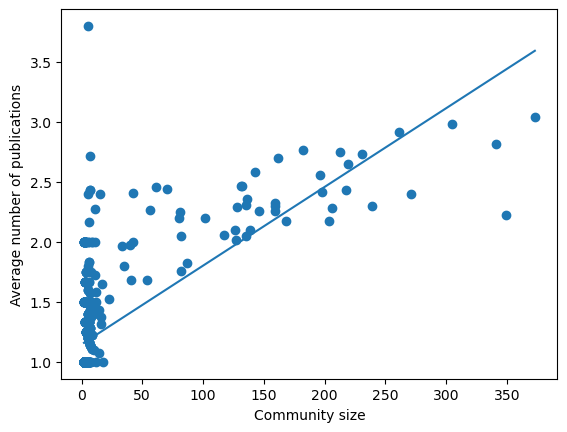

In [24]:
import matplotlib.pyplot as plt

plt.scatter(x,y)
plt.plot(x, model.coef_*x + model.intercept_)
plt.xlabel("Community size")
plt.ylabel("Average number of publications")
plt.show()